# pNEUMA dataset
https://open-traffic.epfl.ch/

## References

Emmanouil Barmpounakis, Nikolas Geroliminis,
On the new era of urban traffic monitoring with massive drone data: The pNEUMA large-scale field experiment,
Transportation Research Part C: Emerging Technologies,
Volume 111,
2020,
Pages 50-71,
ISSN 0968-090X,
https://doi.org/10.1016/j.trc.2019.11.023.

Paul Newson and John Krumm. 2009. Hidden Markov map matching through noise and sparseness. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (GIS '09). Association for Computing Machinery, New York, NY, USA, 336–343. DOI:https://doi.org/10.1145/1653771.1653818

Meert, Wannes, and Verbeke, Mathias. HMM with Non-Emitting States for Map Matching. 2018.
***********************************************************************************************************

In [141]:
import os
import csv
import glob
import math
import warnings
warnings.filterwarnings("ignore")

In [142]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [143]:
import numpy as np
import osmnx as ox
import datetime as dt
import contextily as ctx
import geopandas as gpd
import movingpandas as mpd

In [557]:
from geopy import distance
from datetime import timedelta
from geopandas import GeoDataFrame
from ipywidgets import IntSlider, interact 
from tqdm.notebook import tqdm  
from shapely.geometry import Point, LineString

In [145]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:
#import hdbscan
#from pydmd import DMD

In [7]:
def read_csv(path):
    metadata_cols = [
        'track_id',
        'type',
        'traveled_d',
        'avg_speed',
    ]
    data_cols = [
        'lat',
        'lon',
        'speed',
        'lat_acc',
        'lon_acc',
        'time',
        'track_id',
    ]

    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols) - 1

    metadata_rows = list()
    data_rows = list()

    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [
                float(item) for item in row[metadata_colsize:] if len(item) > 0
            ]
            for i in range(0, len(data_traj), data_colsize):
                data_row = data_traj[i:i + data_colsize] + [track_id]
                data_rows.append(data_row)

    data = pd.DataFrame(data_rows, columns=data_cols)
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

In [8]:
files = []
root = os.getcwd()
path = './data/pNEUMA/'
os.chdir(path)
for file in glob.glob("*.csv"):
    files.append(file)
os.chdir(root)
urlpath = f'{path}{file}'
print(urlpath)

./data/pNEUMA/20181024_d1_0830_0900.csv


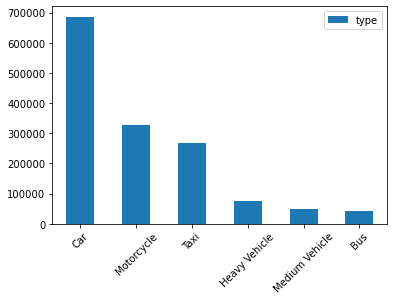

In [9]:
metadata, data = read_csv(urlpath)
df = pd.merge(metadata, data, left_index=True, right_on='track_id')
df['traveled_d'] = df.traveled_d.astype(float)
ax = df.type.value_counts(dropna=False).plot.bar(rot=45, legend=True)

In [10]:
sample = df#[(df.track_id <= 100)]
sample['timestamp'] = sample.apply(
    lambda x: dt.datetime(2018, 10, 24, 8, 30) + timedelta(seconds=x.time),
    axis=1)
sample = sample.set_index('timestamp')

In [11]:
# Initialize points in ETRS89 reference system.
geolocations = gpd.GeoDataFrame(sample,
                                geometry=gpd.points_from_xy(
                                    sample.lon,
                                    sample.lat,
                                    crs={'init': 'epsg:4326'}))
geolocations.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
%%time
trajectories = []
for key, values in geolocations.groupby(['track_id']):
    try:
        trajectory = mpd.Trajectory(values, key)
        if trajectory.df.shape[0] > 1:
            trajectories.append(trajectory)
    except:
        pass

print("Finished creating {} trajectories".format(len(trajectories)))

Finished creating 922 trajectories
CPU times: user 1.16 s, sys: 47.9 ms, total: 1.21 s
Wall time: 1.21 s


In [13]:
%%time
traj_collection = mpd.TrajectoryCollection(trajectories[:])
print(traj_collection)

TrajectoryCollection with 922 trajectories
CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


In [14]:
# Convert to Pseudo-Mercator for cartography.
geolocations = geolocations.to_crs(epsg=3857)
geolocations.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
def get_locations_at_timestamps(col, t):
    pos = []
    for traj in col.trajectories:
        if t >= traj.get_start_time() and t <= traj.get_end_time():
            pos.append({
                'geometry': traj.get_position_at(t),
                'id': str(traj.id),
                'type': traj.df['type'].values[0]
            })
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

In [41]:
# Extract x, y and c from geopandas.
lat = geolocations.geometry.y
lon = geolocations.geometry.x
c = geolocations.speed

In [42]:
# Specify maptiles source.
basemap = ctx.providers.CartoDB.DarkMatter

In [43]:
@interact(i=(0, geolocations.time.max(), 0.5))
def plot(i=0):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(lon, lat, c=c, s=0.05, ec=None, cmap='plasma')

    t = dt.datetime(2018, 10, 24, 8, 30) + timedelta(seconds=i)
    points = get_locations_at_timestamps(traj_collection, t)
    points = points.to_crs(epsg=3857)
    sizes = {
        'Car': 30,
        'Taxi': 30,
        'Bus' : 90,
        'Motorcycle': 5,
        'Medium Vehicle': 50,
        'Heavy Vehicle': 90
    }
    colors = {
        'Car': 'white',
        'Taxi': 'gold',
        'Bus' : 'royalblue',
        'Motorcycle': 'crimson',
        'Medium Vehicle': 'saddlebrown',
        'Heavy Vehicle': 'darkgreen'
    }
    points['sizes'] = points['type'].map(sizes)
    points['colors'] = points['type'].map(colors)
    lat1 = points.geometry.y
    lon1 = points.geometry.x
    sizes = points['sizes']
    colors = points['colors']
    ax.scatter(lon1, lat1, s=sizes, ec=None, c=colors)
    ax.set_axis_off()
    ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

interactive(children=(FloatSlider(value=0.0, description='i', max=818.8, step=0.5), Output()), _dom_classes=('…

********************************************

# Mapmatching

In [19]:
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher

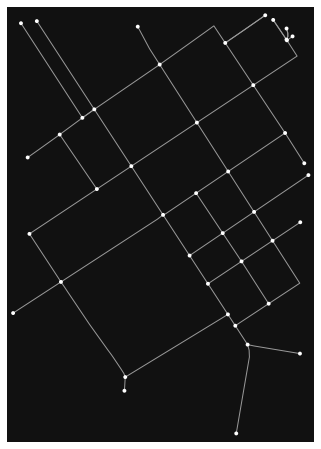

In [20]:
G = ox.graph_from_bbox(sample.lat.max(),
                       sample.lat.min(),
                       sample.lon.max(),
                       sample.lon.min(),
                       simplify=True,
                       retain_all=False,
                       truncate_by_edge=True,
                       clean_periphery = False,
                       network_type='drive')
ax = ox.plot_graph(G)

In [320]:
def make_map(nodes, edges):
    map_con = InMemMap("myosm",
                       use_latlon=True,
                       use_rtree=True,
                       index_edges=True)
    
    for nid, row in nodes[['y', 'x']].iterrows():
        map_con.add_node(nid, (row['y'], row['x']))
    for nid, row in edges.reset_index()[['u', 'v']].iterrows():
        map_con.add_edge(row['u'], row['v'])

    return map_con

In [581]:
%%time
#****************************************************************
# Experiment setup and calibration
#****************************************************************
# Get nodes and edges from graph G
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
# Specify arterial of interest
arterial = edges[(edges.name == 'Ακαδημίας') & (edges.highway == 'secondary') &
                 (edges.lanes == '4')].reset_index()
# Start point of arterial for distance measurement
start = nodes.loc[arterial.loc[7].u].geometry
start = (start.x, start.y)
# End point of arterial
end = nodes.loc[arterial.loc[2].v].geometry
end = (end.x, end.y)
# Geodesic distance
d = distance.GeodesicDistance(start, end).m
# Ground truth distance
D = arterial['length'].sum()
# Error factor
e = D / d
#****************************************************************
# Main mapmatching routine
#****************************************************************
# Make connectivity map
map_con = make_map(nodes, edges)
# List to store trips of interest
trips = []
# Loop through all original trajectories
for i, trajectory in enumerate(traj_collection.trajectories):
    if i == 110:
        trip = trajectory.df.copy(deep=True).reset_index()
        route = [tuple(x) for x in trip[['lat', 'lon']].to_numpy()]
        # Run matcher
        matcher = DistanceMatcher(map_con,
                                  max_dist=200,
                                  min_prob_norm=0.0001,
                                  non_emitting_length_factor=0.5,
                                  obs_noise=10,
                                  max_lattice_width=5,
                                  avoid_goingback=True,
                                  non_emitting_states=False)
        states, _ = matcher.match(route, tqdm=None)
        states_df = pd.DataFrame(states, columns=['u', 'v'])
        # Extract projected coordinates
        coords_list = []
        match = matcher.lattice_best
        for m in match:
            lat, lon = m.edge_m.pi[:2]
            coords_list.append((lat, lon))
        coords_df = pd.DataFrame(coords_list)
        projection = gpd.GeoDataFrame(coords_df,
                                      geometry=gpd.points_from_xy(
                                          coords_df[1],
                                          coords_df[0],
                                          crs={'init': 'epsg:4326'}))
        trip['projection'] = projection['geometry'].values
        # Match trip with the respective street
        trip['u'] = states_df.u.values
        trip['v'] = states_df.v.values
        trip = pd.merge(trip,
                        edges.reset_index(),
                        how='left',
                        left_on=['u', 'v'],
                        right_on=['u', 'v'])
        # Check if arterial is part of the trip
        mask = trip.osmid.isin(arterial.osmid.values)
        if np.any(mask):
            trip = gpd.GeoDataFrame(trip[mask].reset_index(drop=True))
            trip.rename({
                'geometry_x': 'geometry',
                'geometry_y': 'linestring'
            },
                        axis=1,
                        inplace=True)
            # Measure calibrated distance from origin
            distances = []
            for point in trip.projection.values:
                coords = (point.x, point.y)
                d = distance.GeodesicDistance(start, coords).m
                distances.append(d*e)
            trip['distances'] = distances
            trips.append(trip)
        else:
            continue

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.36 s


In [582]:
trips[0]

,timestamp,type,traveled_d,avg_speed,lat,lon,speed,lat_acc,lon_acc,time,track_id,geometry,projection,u,v,key,osmid,oneway,lanes,name,highway,length,linestring,maxspeed,distances
0,2018-10-24 08:31:06.160,Motorcycle,346.02,15.570855,37.98,23.74,17.86,2.07,2.37,66.16,111,POINT (23.73647 37.97884),POINT (23.73653 37.97887),250691755,250692359,0,299644700,True,4,Ακαδημίας,secondary,67.92,"LINESTRING (23.73649 37.97892, 23.73691 37.97841)",NaN,329.95
1,2018-10-24 08:31:06.200,Motorcycle,346.02,15.570855,37.98,23.74,18.17,2.11,2.38,66.20,111,POINT (23.73647 37.97884),POINT (23.73653 37.97887),250691755,250692359,0,299644700,True,4,Ακαδημίας,secondary,67.92,"LINESTRING (23.73649 37.97892, 23.73691 37.97841)",NaN,330.14
2,2018-10-24 08:31:06.240,Motorcycle,346.02,15.570855,37.98,23.74,18.47,2.16,2.39,66.24,111,POINT (23.73647 37.97884),POINT (23.73654 37.97887),250691755,250692359,0,299644700,True,4,Ακαδημίας,secondary,67.92,"LINESTRING (23.73649 37.97892, 23.73691 37.97841)",NaN,330.33
3,2018-10-24 08:31:06.280,Motorcycle,346.02,15.570855,37.98,23.74,18.79,2.23,2.39,66.28,111,POINT (23.73647 37.97884),POINT (23.73654 37.97887),250691755,250692359,0,299644700,True,4,Ακαδημίας,secondary,67.92,"LINESTRING (23.73649 37.97892, 23.73691 37.97841)",NaN,330.42
4,2018-10-24 08:31:06.320,Motorcycle,346.02,15.570855,37.98,23.74,19.12,2.30,2.39,66.32,111,POINT (23.73647 37.97883),POINT (23.73654 37.97887),250691755,250692359,0,299644700,True,4,Ακαδημίας,secondary,67.92,"LINESTRING (23.73649 37.97892, 23.73691 37.97841)",NaN,330.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,2018-10-24 08:31:46.360,Motorcycle,346.02,15.570855,37.98,23.74,39.03,-0.55,1.57,106.36,111,POINT (23.73776 37.97729),POINT (23.73782 37.97732),250691793,6220792260,0,299644700,True,4,Ακαδημίας,secondary,31.51,"LINESTRING (23.73764 37.97753, 23.73777 37.977...",NaN,535.71
1006,2018-10-24 08:31:46.400,Motorcycle,346.02,15.570855,37.98,23.74,38.94,-0.69,1.60,106.40,111,POINT (23.73776 37.97729),POINT (23.73782 37.97732),250691793,6220792260,0,299644700,True,4,Ακαδημίας,secondary,31.51,"LINESTRING (23.73764 37.97753, 23.73777 37.977...",NaN,536.09
1007,2018-10-24 08:31:46.440,Motorcycle,346.02,15.570855,37.98,23.74,38.83,-0.76,1.64,106.44,111,POINT (23.73776 37.97729),POINT (23.73782 37.97732),250691793,6220792260,0,299644700,True,4,Ακαδημίας,secondary,31.51,"LINESTRING (23.73764 37.97753, 23.73777 37.977...",NaN,536.56
1008,2018-10-24 08:31:46.480,Motorcycle,346.02,15.570855,37.98,23.74,38.72,-0.83,1.67,106.48,111,POINT (23.73777 37.97728),POINT (23.73782 37.97731),250691793,6220792260,0,299644700,True,4,Ακαδημίας,secondary,31.51,"LINESTRING (23.73764 37.97753, 23.73777 37.977...",NaN,537.02


***********************************

# Time-space diagram

In [583]:
times = trip.time.values
speed = trip.speed.values
distances = trip.distances.values

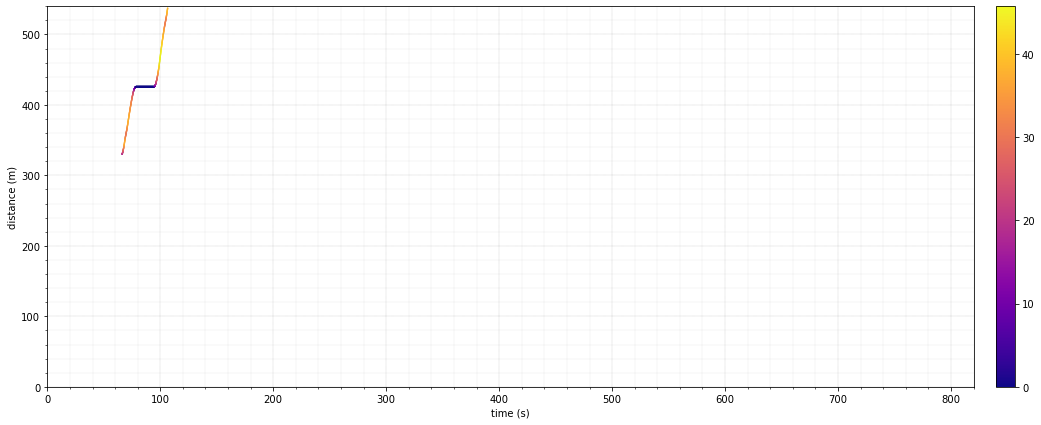

In [584]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.xlim([0, 820])
plt.ylim([0, 540])
ax.minorticks_on()
ax.grid(which='minor', linestyle='--', linewidth=0.1, color='grey')
ax.grid(which='major', linestyle='--', linewidth=0.1, color='black')
ax = plt.scatter(times, distances, c=speed, s=2, ec=None, cmap='plasma')
plt.ylabel('distance (m)')
plt.xlabel('time (s)')
plt.colorbar(ax, pad=0.02)
plt.show()

***********************************************

In [585]:
original = trip.geometry.to_crs(epsg=3857)
projected = trip.projection.to_crs(epsg=3857)

In [586]:
# Extract x, y from geopandas.
lat1 = original.geometry.y
lon1 = original.geometry.x

lat2 = projected.geometry.y
lon2 = projected.geometry.x

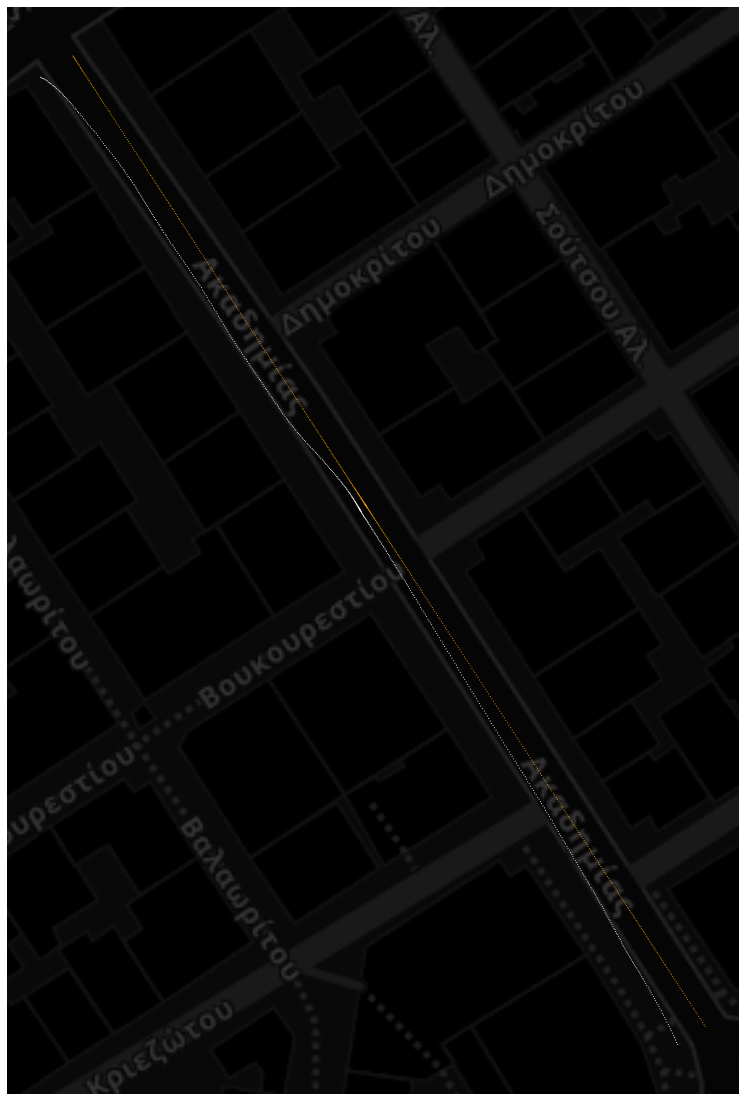

In [587]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(lon2, lat2, s=1, ec=None, c='orange', zorder=1)
ax.scatter(lon1, lat1, s=1, ec=None, c='white', zorder=2)
ax.set_axis_off()
ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

In [588]:
import folium
app = folium.Map(location=[sample.lat.mean(),
                                  sample.lon.mean()],
                      control_scale=True,
                      min_zoom=17,
                      max_zoom=19,
                      zoom_start=17,
                      tiles='CartoDb dark_matter')
folium.PolyLine(coords_list, color='green', weight=1, opacity=1).add_to(app)
folium.PolyLine(route, color='red', weight=0.3, opacity=1).add_to(app)
app